## Exploring data


In [1]:
import pandas as pd
import sqlite3
import requests
import matplotlib.pyplot as plt
import numpy as np

### movie_gross CSV file

In [26]:
movie_gross = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


### tmdb_movie CSV file

In [2]:
tmdb_movie = pd.read_csv("zippedData/tmdb.movies.csv.gz")
tmdb_movie.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [3]:
tmdb_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [4]:
# Filtering movies that are released between 2010 and 2018
tmdb_movie['release_year'] = tmdb_movie['release_date'].str[:4].astype(int)
tmdb_movie = tmdb_movie.loc[(tmdb_movie['release_year'] >= 2010) & (tmdb_movie['release_year'] <= 2018)]
tmdb_movie['release_year'].value_counts()

release_year
2015    3258
2016    3192
2013    3147
2017    3145
2014    3137
2011    2696
2012    2659
2018    2587
2010    2406
Name: count, dtype: int64

From calling the `.info()` method, there seems to be no missing values to deal with. However, the `genre_ids` column is notable because it contains strings that appear to be lists with numerical values.

Since all `genre_ids` are encoded, we match the numeric codes to the actual genre strings, based on information found [here](https://www.themoviedb.org/talk/5f58b094befb0900355684a6), and create another column called `genre` that contains a list of genres.

In [5]:
# A dictionary containing the genre_ids as keys and genres as values
tmdb_genre_list = {
            '28': 'Action',
            '12': 'Adventure',
            '16': 'Animation',
            '35': 'Comedy',
            '80': 'Crime',
            '99': 'Documentary',
            '18': 'Drama',
            '10751': 'Family',
            '14': 'Fantasy',
            '36': 'History',
            '27': 'Horror',
            '10402': 'Music',
            '9648': 'Mystery',
            '10749': 'Romance',
            '878': 'ScienceFiction',
            '10770': 'TVMovie',
            '53': 'Thriller',
            '10752': 'War',
            '37': 'Western'
}

In [6]:
# Changing format of genre_ids to a list
# Note that the numerical values are still in strings

tmdb_movie['genre_ids'] = tmdb_movie['genre_ids'].str.strip('][').str.split(', ')
tmdb_movie['genre_ids'].head()

0        [12, 14, 10751]
1    [14, 12, 16, 10751]
2          [12, 28, 878]
4          [28, 878, 12]
5        [12, 14, 10751]
Name: genre_ids, dtype: object

In [7]:
# Changing the numerical values to actual genres
# Creating a function to match with the genre list created above.
# If the number is not in the list, return 'Unknown'
def clean_genre(genre):
    new_genre = []
    for id in genre:
        if id in tmdb_genre_list.keys():
            new_genre.append(tmdb_genre_list[id])
        else:
            new_genre = 'Unknown'
    return new_genre

# Using this function to change numbers to genres
tmdb_movie['genre'] = tmdb_movie['genre_ids'].map(clean_genre)



One of the notable categories is the **Unknown** category. This category may contain a numeric genre_id that is not specified in the `tmdb_genre_list` dictionary, or have no numeric id. Since there are 2479 entries with the **Unknown** out of about 26500, we decide to drop the movies that have the **Unknown** category.

In [8]:
# Dropping the Unknown movies
tmdb_movie = tmdb_movie.loc[tmdb_movie['genre'] != 'Unknown']
tmdb_movie.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23755 entries, 0 to 26516
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         23755 non-null  int64  
 1   genre_ids          23755 non-null  object 
 2   id                 23755 non-null  int64  
 3   original_language  23755 non-null  object 
 4   original_title     23755 non-null  object 
 5   popularity         23755 non-null  float64
 6   release_date       23755 non-null  object 
 7   title              23755 non-null  object 
 8   vote_average       23755 non-null  float64
 9   vote_count         23755 non-null  int64  
 10  release_year       23755 non-null  int64  
 11  genre              23755 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.4+ MB


In [9]:
# Creating 7 columns to store individaul genres for movies that have more than one genre
split = pd.DataFrame(tmdb_movie['genre'].to_list(), columns = ['main_genre', 'genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7'])
tmdb_movie = pd.concat([tmdb_movie, split], axis=1)
tmdb_movie.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,release_year,genre,main_genre,genre2,genre3,genre4,genre5,genre6,genre7
0,0.0,"[12, 14, 10751]",12444.0,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788.0,2010.0,"[Adventure, Fantasy, Family]",Adventure,Fantasy,Family,None,None,None,None
1,1.0,"[14, 12, 16, 10751]",10191.0,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610.0,2010.0,"[Fantasy, Adventure, Animation, Family]",Fantasy,Adventure,Animation,Family,None,None,None
2,2.0,"[12, 28, 878]",10138.0,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368.0,2010.0,"[Adventure, Action, ScienceFiction]",Adventure,Action,ScienceFiction,None,None,None,None
4,4.0,"[28, 878, 12]",27205.0,en,Inception,27.920,2010-07-16,Inception,8.3,22186.0,2010.0,"[Action, ScienceFiction, Adventure]",Adventure,Fantasy,Family,None,None,None,None
5,5.0,"[12, 14, 10751]",32657.0,en,Percy Jackson & the Olympians: The Lightning T...,26.691,2010-02-11,Percy Jackson & the Olympians: The Lightning T...,6.1,4229.0,2010.0,"[Adventure, Fantasy, Family]",Animation,Family,Comedy,None,None,None,None


In [10]:
# Filtering to only analyze from movies with more than 10 votes
reviews_more_than_10 = tmdb_movie.loc[tmdb_movie['vote_count'] > 10]
reviews_more_than_10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9781 entries, 0 to 26464
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         9781 non-null   float64
 1   genre_ids          9781 non-null   object 
 2   id                 9781 non-null   float64
 3   original_language  9781 non-null   object 
 4   original_title     9781 non-null   object 
 5   popularity         9781 non-null   float64
 6   release_date       9781 non-null   object 
 7   title              9781 non-null   object 
 8   vote_average       9781 non-null   float64
 9   vote_count         9781 non-null   float64
 10  release_year       9781 non-null   float64
 11  genre              9781 non-null   object 
 12  main_genre         8824 non-null   object 
 13  genre2             4784 non-null   object 
 14  genre3             2124 non-null   object 
 15  genre4             604 non-null    object 
 16  genre5             132 non-n

In [11]:
# Checking number of movies per genre
tmdb_movie['main_genre'].value_counts()

main_genre
Drama             4842
Documentary       4386
Comedy            3600
Horror            2190
Action            1618
Thriller          1523
Animation          894
Romance            690
Music              670
ScienceFiction     565
Crime              528
Adventure          527
Family             457
TVMovie            365
Fantasy            308
Mystery            285
History            126
War                101
Western             80
Name: count, dtype: int64

Text(0, 0.5, 'Number of Movies')

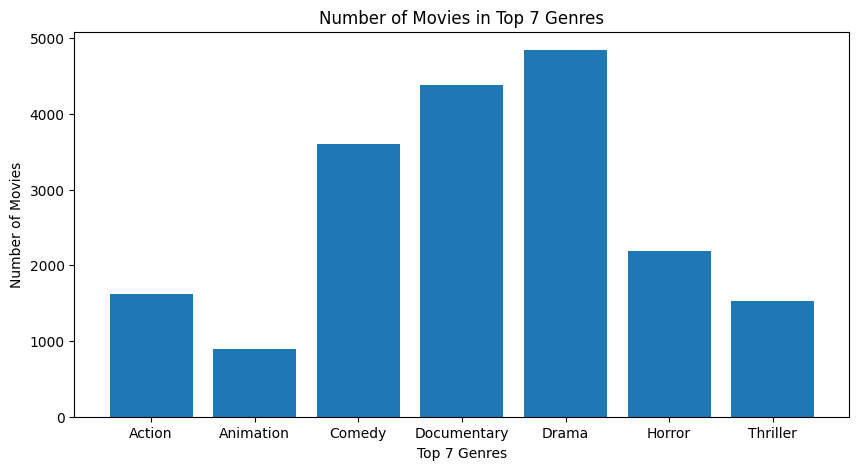

In [12]:
# Visualizing the number of movies in top 7 movie genres
# First, creating a dictionary with genres and counts
top_7_genres_index = list(tmdb_movie['main_genre'].value_counts()[:7].keys())
top_7_genre_counts = tmdb_movie['main_genre'].value_counts()[:7]
top_7_genres = dict(zip(top_7_genres_index, top_7_genre_counts))

# Then, sorting them alphabetically for the visualization
top_7_genres_index.sort()
top_7_genres_sorted = {i: top_7_genres[i] for i in top_7_genres_index}

# Visualizing in a bar graph
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(top_7_genres_sorted.keys(), top_7_genres_sorted.values())
ax.set_title("Number of Movies in Top 7 Genres")
ax.set_xlabel("Top 7 Genres")
ax.set_ylabel("Number of Movies")

In [13]:
# Grouping by genre for top 7 genre, and getting the vote average
genre_tmdb = tmdb_movie.loc[tmdb_movie['main_genre'].isin(top_7_genres)].groupby('main_genre')
genre_tmdb['vote_average'].mean()
genre_tmdb['popularity'].mean()

main_genre
Action         2.974123
Animation      3.328895
Comedy         3.226962
Documentary    3.404913
Drama          2.959585
Horror         3.057282
Thriller       2.897797
Name: popularity, dtype: float64

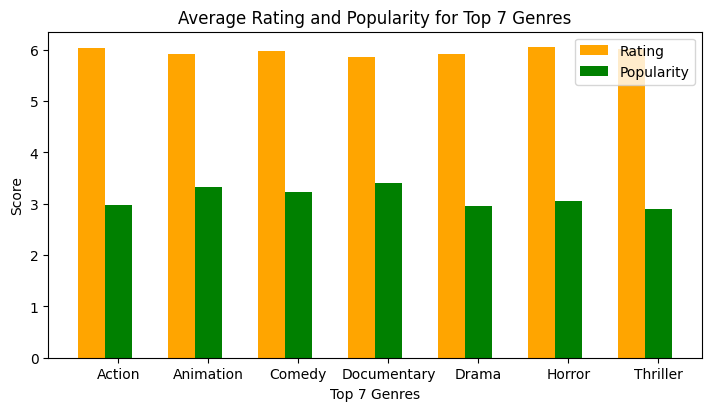

In [14]:
# Visualizing the top 7 genres and their average ratings
fig, ax = plt.subplots(figsize=(7,4), layout='constrained')

x = np.arange(len(top_7_genres_sorted))
y_rating = genre_tmdb['vote_average'].mean()
ax.bar(x - 0.3, y_rating, 0.3, color='orange', label='Rating')

y_popularity = genre_tmdb['popularity'].mean()
ax.bar(top_7_genres_sorted.keys(), y_popularity, 0.3, color='green', label='Popularity')


ax.set_title("Average Rating and Popularity for Top 7 Genres")
ax.set_xlabel("Top 7 Genres")
ax.set_ylabel("Score")
ax.legend()

### tn_movie_budgests CSV file

In [10]:
tn_movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")
tn_movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [36]:
movie_info = pd.read_table("zippedData/rt.movie_info.tsv.gz")
movie_info.head()


,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [28]:
reviews = pd.read_csv("zippedData/rt.reviews.tsv.gz", sep='\t', encoding='latin1')
reviews['id'].value_counts()

id
782     338
1067    275
1525    262
1777    260
1083    260
       ... 
1393      1
411       1
770       1
1125      1
1526      1
Name: count, Length: 1135, dtype: int64

In [35]:
grouped_reviews = reviews.groupby('id')
grouped_reviews.count()['review'].describe()

count    1135.000000
mean       43.056388
std        56.670793
min         0.000000
25%         4.000000
50%        15.000000
75%        67.000000
max       338.000000
Name: review, dtype: float64

In order to unzip the database file, run the following prompt in terminal

`tar -xf "zippedData/im.db.zip"`

In [4]:
conn = sqlite3.connect("im.db")


In [4]:
pd.read_sql("""
SELECT *
FROM persons
""", conn)

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer
